In [9]:
import pandas as pd
import numpy as np
import torch
import copy
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import time,random

## CONSTANTS REQUIRED DURING THE ENTIRE SCRIPT

In [2]:
epochs = 100
learning_rate = 1e-3
batch_size = 16
seq_len = 24
RANDOM_SEED = 557
SOS_token = 0.0
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
teacher_forcing_ratio = 0.5
embedding_dim = 8
n_features=1
input_data_path = "/home/sonakshireddy/Documents/soil/merged_data_tera.csv"
output_model_path = "/home/sonakshireddy/Documents/soil_ae_models/"
output_model_file = f'ae_{seq_len}_seqlen_batch_{batch_size}_epoch_{epochs}_embedding_{embedding_dim}_lr_{learning_rate}_te_{teacher_forcing_ratio}_dp.pkl'

## RETRIEVING DATA FROM CSV FILE AND FILTERING TO GET DATA FROM  2011 TO 2018

In [3]:
filtered = pd.read_csv(input_data_path)
filtered.date = pd.to_datetime(filtered.date)
del filtered['Unnamed: 0']
filtered.index = filtered.date
filtered['SWC_PI_F_1_1_A'] = filtered['SWC_PI_F_1_1_A'].astype(np.float32)
data = filtered[filtered.index.year.isin(range(2011,2019))]['SWC_PI_F_1_1_A']

## ADD NOISE TO INPUT DATA

In [4]:
def add_noise(x):
    A = np.random.random(x.size())>.3
    A = torch.tensor(A.astype(np.float32))
    return A*x

## CREATING INPUT AND OUTPUT SEQUENCES FROM THE DATA

In [5]:
def get_sequence(data,batch_size,seq_len):
    input_sequence = []
    batch_array = []
    for i,d in enumerate(data[:len(data)-seq_len+1]):
        seq = data[i:i+seq_len]
        if np.nan not in seq:
            if len(batch_array)==batch_size:
                input_sequence.append(np.array(batch_array,dtype=np.float32))
                batch_array = []
                if len(seq) == seq_len:
                    batch_array.append(np.array(seq, dtype=np.float32).reshape(-1, 1))
            else:
                if len(seq) == seq_len:
                    batch_array.append(np.array(seq, dtype=np.float32).reshape(-1, 1))
    return input_sequence

In [6]:
input_sequence = get_sequence(data,batch_size,seq_len)

In [7]:
noisy_sequence = get_sequence(add_noise(torch.tensor(list(data))),batch_size,seq_len)

### RMSE LOSS DEFINITION

In [8]:
def RMSELoss(yhat,y):
        return torch.sqrt(torch.mean((yhat-y)**2))

## AUTO ENCODER WITH ATTENTION DEFINITION

In [11]:

class Encoder(nn.Module):
    def __init__(self, n_features, embedding_dim=64,batch_size = 32,num_layers=2):
        super(Encoder, self).__init__()
        self.n_features = n_features
        self.hidden_dim = 2*embedding_dim
        self.num_layers=num_layers
        self.batch_size = batch_size
        self.rnn1 = nn.GRU(
            input_size=n_features,
            hidden_size=self.hidden_dim,
            num_layers=self.num_layers,
            dropout=0.2,
            batch_first=True
        )
       
    def forward(self, x,hidden_n):
        x = x.reshape((self.batch_size, 1,-1))
        x, hidden_n = self.rnn1(x,hidden_n)
        return x,hidden_n

    def initHidden(self):
        return torch.zeros(self.num_layers, self.batch_size, self.hidden_dim, device=device)


class Decoder(nn.Module):
    def __init__(self,  seq_len,input_dim=64,n_features=1,batch_size=32,num_layers=2):
        super(Decoder, self).__init__()
        self.input_dim = 2 * input_dim
        self.hidden_dim, self.n_features = 2 * input_dim, n_features
        self.seq_len = seq_len
        self.batch_size = batch_size
        self.num_layers=num_layers
        self.attn = nn.Linear(self.input_dim +self.n_features, self.seq_len)
        self.attn_combine = nn.Linear(self.input_dim + self.n_features, self.input_dim)
        self.rnn1 = nn.GRU(
            input_size=self.input_dim,
            hidden_size=self.hidden_dim,
            num_layers=self.num_layers,
            dropout=0.2,
            batch_first=True
        )
        
        self.output_layer = nn.Linear(self.hidden_dim, n_features)

    def forward(self, x, hidden_n,encoder_op):
        x= x.view(1,self.batch_size, -1)
        encoder_op = encoder_op.reshape((self.batch_size,self.seq_len, self.input_dim))
        attn_weights = F.softmax(
            self.attn(torch.cat((x[0], hidden_n[-1]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(1),
                                 encoder_op)
        output = torch.cat((x[0], attn_applied.view(1,self.batch_size,-1)[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)
        output, hidden_n = self.rnn1(output.view(self.batch_size,1,-1),hidden_n)
        return self.output_layer(output),hidden_n

    def initHidden(self):
        return torch.zeros(self.num_layers, self.batch_size, self.hidden_dim, device=device)


## TRAINING MODEL DEFINITION FOR A MINI BATCH

In [12]:

def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)
    batch_size = input_tensor.size(1)
    encoder_outputs = torch.zeros(target_length ,batch_size,encoder.hidden_dim, device=device)

    loss = 0
    rmse_loss = 0
    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[:, 0]

    decoder_input = torch.tensor([[SOS_token]]*batch_size, device=device)

    decoder_hidden = encoder_hidden
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output.view(batch_size), target_tensor[di].view(batch_size))
            rmse_loss += RMSELoss(decoder_output.view(batch_size), target_tensor[di].view(batch_size))
            decoder_input = target_tensor[di]

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden, encoder_outputs)

            loss += criterion(decoder_output.view(batch_size), target_tensor[di].view(batch_size))
            rmse_loss += RMSELoss(decoder_output.view(batch_size), target_tensor[di].view(batch_size))
            decoder_input = decoder_output.view(batch_size,1).squeeze().detach()  # detach from history as input

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length, rmse_loss.item()/ target_length


## EVALUATING AUTOENCODER MODEL USING MAE AND RMSE LOSS

In [13]:
def evaluate(encoder, decoder, input_tensor, target_tensor, criterion):
    with torch.no_grad():
        loss=0
        rmse_loss = 0
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()
        batch_size = input_tensor.size(1)
        encoder_outputs = torch.zeros(input_length , batch_size,encoder.hidden_dim, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[:, 0]

        decoder_input = torch.tensor([[SOS_token]]*batch_size, device=device)  # SOS

        decoder_hidden = encoder_hidden
        decoder_ops = torch.zeros(input_length ,batch_size,1, device=device)

        for di in range(input_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_ops[di] = decoder_output.view(batch_size,1)
            decoder_input = decoder_output.view(batch_size,1).squeeze().detach()  # detach from history as input
            loss += criterion(decoder_output.view(batch_size), target_tensor[di].view(batch_size))
            rmse_loss += RMSELoss(decoder_output.view(batch_size), target_tensor[di].view(batch_size))
            
        return loss.item() / input_length, rmse_loss.item()/ input_length,decoder_ops

## TRAINING MODEL FOR THE ENTIRE DATA AND CALCULATING LOSS

In [14]:
def train_model(encoder,decoder,encoder_optimizer,decoder_optimizer,criterion, train_dataset, val_dataset,batch_size=32, n_epochs=100):
    history = dict(train=[], val=[])
    best_loss = 10000.0
    best_encoder_wts = copy.deepcopy(encoder.state_dict())
    best_decoder_wts = copy.deepcopy(decoder.state_dict())
    best_encoder_optimiser = copy.deepcopy(encoder_optimizer.state_dict())
    best_decoder_optimiser = copy.deepcopy(decoder_optimizer.state_dict())
    for epoch in range(1, n_epochs + 1):
#         model = model.train()
        train_losses = []
        train_rmses = []
        for seq_true,noisy_true in train_dataset:
            seq_true = torch.tensor(seq_true).view(-1,batch_size).to(device)
            noisy_data = torch.tensor(noisy_true).view(-1,batch_size).to(device)
#             print(seq_true.size())
            loss,rmse = train(noisy_data, seq_true, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
            train_losses.append(loss)
            train_rmses.append(rmse)
        val_losses = []
        val_rmses = []
        with torch.no_grad():
            for seq_true,noisy_data in val_dataset:
                seq_true = torch.tensor(seq_true).view(-1,batch_size)
                noisy_data = torch.tensor(noisy_data).view(-1,batch_size)
                loss,rmse,_=evaluate(encoder,decoder,noisy_data,seq_true,criterion)
                val_losses.append(loss)
                val_rmses.append(rmse)
        train_loss = np.mean(train_losses)
        val_loss = np.mean(val_losses)
        train_rmse = np.mean(train_rmses)
        val_rmse = np.mean(val_rmses)
        history['train'].append(train_loss)
        history['val'].append(val_loss)
        if val_loss < best_loss:
            best_loss = val_loss
            best_encoder_wts = copy.deepcopy(encoder.state_dict())
            best_decoder_wts = copy.deepcopy(decoder.state_dict())
            best_encoder_optimiser = copy.deepcopy(encoder_optimizer.state_dict())
            best_decoder_optimiser = copy.deepcopy(decoder_optimizer.state_dict())
        print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss} \n train rmse {train_rmse} val_rmse {val_rmse}')
    encoder.load_state_dict(best_encoder_wts)
    decoder.load_state_dict(best_decoder_wts)
    encoder_optimizer.load_state_dict(best_encoder_optimiser)
    decoder_optimizer.load_state_dict(best_decoder_optimiser)
    return history


### SPLITTING THE TRAIN AND VAL DATA

In [15]:
train_dataset, val_dataset = train_test_split(
  list(zip(input_sequence,noisy_sequence)),
  test_size=0.124,
  random_state=RANDOM_SEED,
    shuffle = False
)

## DEFINING THE AUTOENCODER MODEL WITH A PARTICULAR SET OF PARAMETERS

In [16]:
criterion = nn.L1Loss()
encoder = Encoder(n_features, embedding_dim,batch_size).to(device)
decoder = Decoder(seq_len,embedding_dim, n_features,batch_size).to(device)

encoder_optimizer = torch.optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=learning_rate)

## CALLING THE TRAIN FUNCTION TO ITERATE FOR A GIVEN NO. OF EPOCHS AND PRINT LOSS

In [ ]:
h = train_model(encoder, decoder,encoder_optimizer,decoder_optimizer,criterion, train_dataset,val_dataset,batch_size = 16,n_epochs=150)

Epoch 1: train loss 10.439188279401167 val loss 8.015655030332068 
 train rmse 10.488790555240204 val_rmse 8.07200583611049
Epoch 2: train loss 3.0583899321087786 val loss 2.6633303327595486 
 train rmse 3.1692455247485998 val_rmse 2.7853806378940744
Epoch 3: train loss 1.2782116417657614 val loss 1.555288075524218 
 train rmse 1.4104750328003484 val_rmse 1.6830653768105834
Epoch 4: train loss 0.9416245625928549 val loss 1.8817452445407123 
 train rmse 1.074479129152142 val_rmse 1.9892631607020603
Epoch 5: train loss 0.8521920506581995 val loss 1.8697995968236059 
 train rmse 0.9831403426385218 val_rmse 1.9788081492936498
Epoch 6: train loss 0.737885334173072 val loss 1.6410099042798667 
 train rmse 0.8663130680549136 val_rmse 1.7511147342658802


### SAVING THE MODEL TO LOCAL FOR FUTURE PREDICTIONS

In [128]:
PATH = output_model_path + output_model_file
torch.save({
            'encoder_state_dict': encoder.state_dict(),
            'decoder_state_dict':decoder.state_dict(),
            'e_optimizer_state_dict': encoder_optimizer.state_dict(),
            'd_optimizer_state_dict': decoder_optimizer.state_dict(),
            }, PATH)

### PLOTTING TRAIN AND VALIDATION LOSS SAVED IN FILES

In [205]:
with open("/home/sonakshireddy/Documents/train_val_loss/seq_len_24_bs_16_lr_1e-3_emb_8_dp_num_lay_2_dropout_0.1_train.txt") as f:
    d = f.read().split("\n")
train_loss = list(map(float,d))

In [206]:
with open("/home/sonakshireddy/Documents/train_val_loss/seq_len_24_bs_16_lr_1e-3_emb_8_dp_num_lay_2_dropout_0.1_val.txt") as f:
    d = f.read().split("\n")
val_loss = list(map(float,d))

In [207]:
loss_df = pd.DataFrame(zip(train_loss,val_loss),columns=['train_loss','val_loss'])
loss_df.plot()

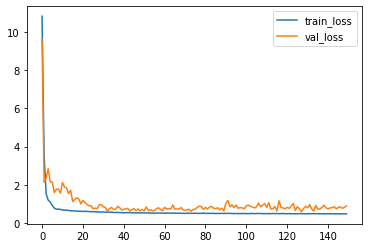

### PREDICTION OF MODEL ON TEST DATA (KENDALL & TONZI OF SOILSCAPE)

In [534]:
## to get tonzi data of year 2015 (full year present)
test = filtered[filtered.index.year==2015]['TonziRanch_CAn=408_d=5']
test[test<1] = 0

/home/sonakshireddy/virtual_environment/venv/lib/python3.6/site-packages/pandas/core/generic.py:8765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [503]:
## to get kendall data of year 2017 (full year present)
df = pd.read_csv("/home/sonakshireddy/Documents/soil/soil/pred_exp/merge_all_result_hourly.csv",sep=";")
df.index = pd.to_datetime(df['date'])
test = df[df.index.year==2017]['Kendall_AZ_n=1408_d=5']

In [535]:
## filling na with 0 (since noise in the input data is converted to 0 during training)
test = test.fillna(0)

In [536]:
test_ip = get_sequence(test,batch_size,seq_len)
test_ip = torch.tensor(test_ip)

### LOADING MODEL FROM FILE

In [537]:
PATH = output_model_path + output_model_file
checkpoint = torch.load(PATH)
embedding_dim = 8
e1 = Encoder(n_features, embedding_dim,batch_size).to(device)
d1 = Decoder(seq_len,embedding_dim, n_features,batch_size).to(device)
e1.load_state_dict(checkpoint['encoder_state_dict'])
d1.load_state_dict(checkpoint['decoder_state_dict'])
encoder_optimizer.load_state_dict(checkpoint['e_optimizer_state_dict'])
decoder_optimizer.load_state_dict(checkpoint['d_optimizer_state_dict'])

### CALLING EVALUATION FUNCTION ON TEST DATA

In [538]:
val_losses = []
rmses = []
outputs=[]
with torch.no_grad():
    for seq_true in test_ip:
        seq_true = torch.tensor(seq_true).view(-1,batch_size)
        loss,rmse,output=evaluate(e1,d1,seq_true,seq_true,criterion)
        val_losses.append(loss)
        rmses.append(rmse)
        outputs.append(output.view(batch_size,-1,1).detach().numpy())
val_loss = np.mean(val_losses)
rmse_loss = np.mean(rmses)
print(f'test loss {val_loss} rmse {rmse_loss}')

/home/sonakshireddy/virtual_environment/venv/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


test loss 0.795406388639676 rmse 0.9672571706684517


### PLOTTING THE INPUT TEST DATA AND OUTPUT MODEL PREDICTIONS

In [539]:
outputs_flat = torch.tensor(outputs).view(-1,seq_len)
result_flat = []
for i in range(0,outputs_flat.size()[0],seq_len):
    result_flat.append(np.array(outputs_flat[i]))
result_flat = torch.tensor(result_flat).view(-1,1)

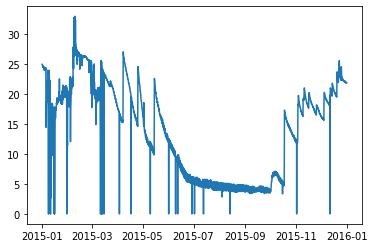

In [542]:
plt.plot(test.index[:result_flat.size()[0]]
         ,test[:result_flat.size()[0]])


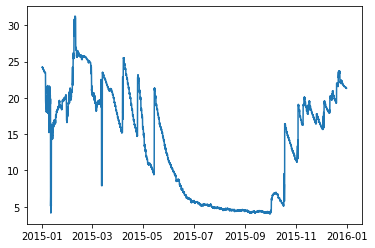

In [543]:
plt.plot(test.index[:result_flat.shape[0]]
         ,result_flat)

In [515]:
# d= pd.DataFrame(zip(['128','64','32','16'],[0.505402091751488, 0.46571879952209405, 0.38053600353876155, 0.4761529921450049],[0.4771891025545145, 0.5250349153501285, 0.4961161183263152, 0.4749210866086993]),columns=['seq','tr','val'])
# d.index = d['seq']
# del d['seq']
# d.index = map(int,d.index)
# d = d.sort_index()
# d.index = map(str,d.index)

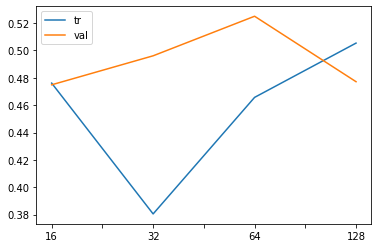

In [530]:
# d.plot()